# Football Player Recommendation using LSH

## Import libraries and data

In [1]:
!pip install datasketch

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasketch import MinHashLSH, MinHash
from types import SimpleNamespace

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 4.2 MB/s eta 0:00:00


In [2]:
url = "https://raw.githubusercontent.com/Computational-Tools-in-DS-G42/datasets/main/data.csv"
init_df = pd.read_csv(url, encoding="latin1", sep=",")

## Finding Similar Players using LSH (Locality-Sensitive Hashing)

### Data Process

In [145]:
# Removing some of the columns that distors the similar players
cols_to_drop = ["club", "motm", "offsides_won", "league",  "fee", "traded", "club_position", "season", 'apps', 'age', 'mins', 'rating']
df_clean = init_df.drop(columns=cols_to_drop)
# Removing duplicate players
df_clean = df_clean.drop_duplicates(subset='name', keep='first')
df_clean = df_clean.reset_index(drop=True)


In [146]:
cols = [ 'goals', 'assists', 'yel',
       'red', 'shots', 'ps%', 'aerials_won', 'tackles', 'interceptions',
       'fouls', 'clearances', 'dribbled', 'blocks', 'own_goals', 'key_passes',
       'dribblings', 'fouled', 'offsides', 'dispossed', 'bad_controls',
       'avg_passes', 'crosses', 'long_passes', 'through_passes']

for curr in cols:
  df_clean[curr] = pd.to_numeric(df_clean[curr], errors='coerce').fillna(0)

df_clean[cols] = df_clean[cols].astype(float)

### Locality-sensive Hashing (LSH)

In [147]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.difference(["name"]).tolist()
categorical_cols = ["position"]

range = 5
# Converts each player row into tokens
def make_tokens(row):
    tokens = {f"{c}={row[c]}" for c in categorical_cols}
    tokens |= {f"{c}={int(row[c]//range*range)}" for c in numeric_cols}
    return tokens

token_sets = [make_tokens(r) for _, r in df_clean.iterrows()]

lsh, mhashes = MinHashLSH(threshold=0.3, num_perm=64), []

for i, s in enumerate(token_sets):
    m = MinHash(num_perm=64)
    for t in s: m.update(str(t).encode("utf8"))
    lsh.insert(str(i), m); mhashes.append(m)


In [148]:
def find_similar_players_lsh(player_name, k=5):

    # check if target player is available
    matches = df_clean.index[df_clean['name'] == player_name].tolist()
    if not matches:
        print("Player not found")
    else:
        player_idx = matches[0]

    i = player_idx
    ids = [int(j) for j in lsh.query(mhashes[i])]
    sims = [(j, len(token_sets[i]&token_sets[j])/len(token_sets[i]|token_sets[j])) for j in ids if j!=i]
    sims = sorted(sims, key=lambda x: x[1], reverse=True)[:k]

    # Building a data frame
    similar_df = df_clean.loc[[j for j, _ in sims]].copy()
    similar_df['similarity'] = [s for _, s in sims]
    similar_df.reset_index(drop=True, inplace=True)

    target_player = SimpleNamespace(
        name=df_clean.loc[i, 'name'],
        pos=df_clean.loc[i, 'position'])
    
    return similar_df, target_player

In [186]:
player_name = "Cristiano Ronaldo"
num_sim_player = 125
sim_df, target = find_similar_players_lsh(player_name, num_sim_player)

In [191]:
sim_df.head(5)

,name,position,goals,assists,yel,red,shots,ps%,aerials_won,tackles,interceptions,fouls,clearances,dribbled,blocks,own_goals,key_passes,dribblings,fouled,offsides,dispossed,bad_controls,avg_passes,crosses,long_passes,through_passes,similarity
0,Benjamin Kohler,FW,4.0,5.0,2.0,0.0,0.8,77.5,0.2,1.5,1.2,0.7,0.3,0.6,0.2,0.0,1.2,1.1,1.9,0.4,1.1,0.0,27.1,0.9,1.0,0.2,0.8
1,Nicolas Anelka,FW,11.0,7.0,0.0,0.0,3.0,78.6,1.1,0.8,0.9,0.6,0.1,0.2,0.1,0.0,1.8,1.0,1.1,0.8,2.0,0.0,31.4,0.6,1.0,0.1,0.8
2,Dan James,FW,3.0,6.0,4.0,0.0,1.3,78.7,0.2,0.6,0.2,0.4,0.2,1.2,0.1,0.0,0.8,0.8,1.7,0.1,0.9,1.4,21.2,0.5,0.4,0.1,0.8
3,Vladimir Darida,FW,3.0,6.0,3.0,0.0,1.6,75.8,1.5,1.7,1.4,1.8,0.9,1.2,0.3,0.0,1.3,2.0,1.6,0.1,1.8,1.2,43.2,0.4,2.3,0.0,0.8
4,Gonzalo Higuain,FW,27.0,5.0,3.0,0.0,3.1,81.5,0.1,0.3,0.5,0.8,0.3,0.5,0.0,0.0,1.6,1.4,1.0,1.3,1.7,0.0,24.1,0.3,0.9,0.3,0.8


## Graph

In [181]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [194]:
def display_position_wordcloud(target_player, df_data):

    player_name = target.name
    position = target.pos

    print(f"Player: {player_name} | Position: {position}")

    freq = {
        row['name']: float(row['similarity'])
        for _, row in df_data.iterrows()
        if pd.notna(row['similarity'])
    }

    if not freq:
        raise ValueError("No similarity scores available to generate the wordcloud.")

    fig, ax = plt.subplots(figsize=(14, 10), facecolor="#f8f9fa")

    wc = WordCloud(
        width=1200, height=800,
        background_color="white",
        colormap="viridis",
        max_words=80,
        collocations=False,
        random_state=42,
        scale=2
    ).generate_from_frequencies(freq)

    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(
        f"{player_name}: {position}\n",
        fontsize=18, fontweight="bold", color="#2c3e50", pad=20
    )
    ax.axis("off")

    plt.tight_layout()
    plt.show()

    return fig, freq

Player: Cristiano Ronaldo | Position: FW


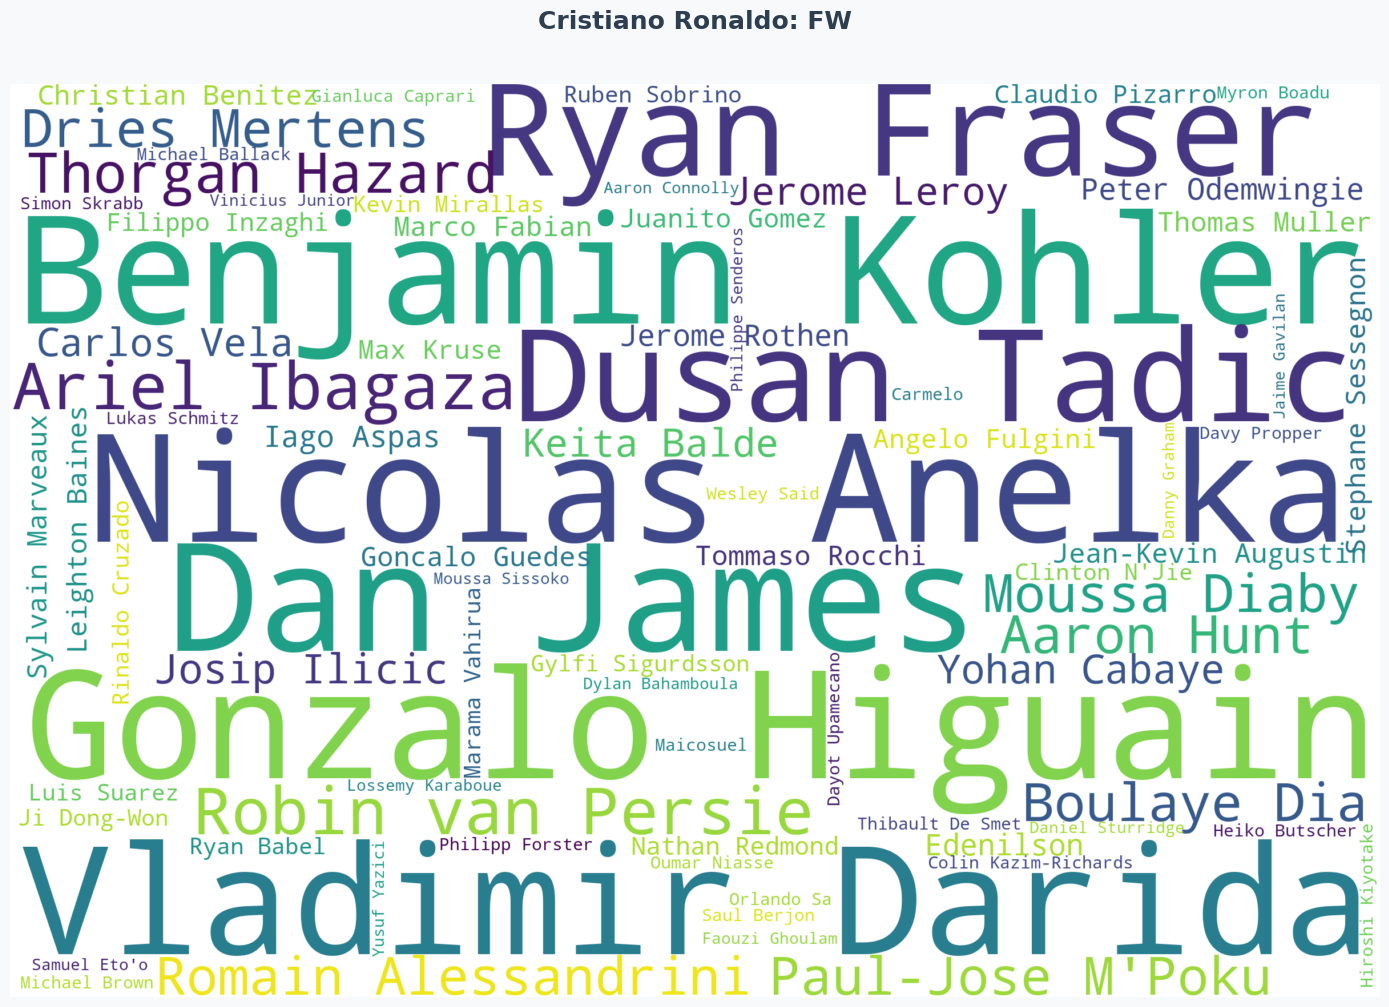

In [195]:
fig, freq = display_position_wordcloud(target, sim_df)